ENGR 418 - Group 33\
Matthew Ofina - 84790435\
Duncan Raenstein - 57709628

In [73]:
# ============================================================
# This cell imports necassary libraries
# ============================================================

# Basic imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
import cv2

In [74]:
# =========================================================================================
# This cell is the feature engineering cell and extracts features. It also contains helper
# functions to load data and get labels.
# =========================================================================================

def get_label(file_name):
    """
    This function extracts the label from the file name.
    """
    if file_name.startswith('2'): return 0
    elif file_name.startswith('c'): return 1
    elif file_name.startswith('r'): return 2
    elif file_name.startswith('s'): return 3
    return 0

def extract_engineered_features_opencv(im_array):
    """
    Extracts 12 Base Features:
    - 5 Geometric (Area, Compactness, Solidity, Aspect Ratio, Rectangularity)
    - 7 Hu Moments (Shape Invariants)
    """

    # Makes sure data is the corret type
    if im_array.dtype != np.uint8:
        im_array = im_array.astype(np.uint8)

    # Preprocessing, converts to binary
    inv_im = cv2.bitwise_not(im_array)
    _, binary = cv2.threshold(inv_im, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Strong morphological closing (5x5) to solidify shapes
    kernel = np.ones((5,5), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    
    # Converts image to contour format
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours: return np.zeros(12)
    cnt = max(contours, key=cv2.contourArea)
    
    # Extracts 5 Geometric Features
    # Area
    area = cv2.contourArea(cnt)
    
    # Compactness (P^2 / A)
    perimeter = cv2.arcLength(cnt, True)
    compactness = (perimeter ** 2) / area if area > 0 else 0

    # Solidity (Area / Convex Hull)
    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solidity = area / hull_area if hull_area > 0 else 0
    
    # Aspect Ratio (Rotation Invariant)
    rect = cv2.minAreaRect(cnt) 
    (center), (width, height), angle = rect
    dims = sorted([width, height])
    aspect_ratio = dims[1] / dims[0] if dims[0] > 0 else 0
    
    # Rectangularity (w / h)
    rect_area = width * height
    rectangularity = area / rect_area if rect_area > 0 else 0

    # Extracts 7 Hu Moments
    moments = cv2.moments(cnt)
    hu = cv2.HuMoments(moments).flatten()

    # Log scale for numerical stability
    hu_log = [ -1 * np.sign(h) * np.log10(np.abs(h) + 1e-7) for h in hu ]
    
    # Creates a combined Feature Vector with all of the previously extracted features
    features = np.array([
        area, compactness, solidity, aspect_ratio, rectangularity,
        hu_log[0], hu_log[1], hu_log[2], hu_log[3], hu_log[4], hu_log[5], hu_log[6]
    ])
    
    return features

def get_data_stage2(folder_path):
    """
    This fuction loads all images from the specified folder and extracts features and labels.
    """

    # Lists all image files in the folder
    file_names = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg'))]
    features_list = []
    labels_list = []

    # iterates through each file, extracts features and labels
    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)
        im = Image.open(file_path).convert('L')
        im_array = np.array(im)
        feats = extract_engineered_features_opencv(im_array)
        lbl = get_label(file_name)
        features_list.append(feats)
        labels_list.append(lbl)
        
    # Converts lists to numpy arrays and returns
    return np.array(features_list), np.array(labels_list)


In [75]:
# =========================================================================================
# Training cell with L1 regularization
# =========================================================================================

def training_function(path):
    """
    This function inputs the extracted features into a Logistic Regression pipeline with:
    1. Scaling (StandardScaler)
    2. Poly Expansion (12 Base -> ~90 Interactions)
    3. SelectKBest (Keeps Top 10) - REDUCED from 40 to prevent overfitting.
    4. Logistic Regression with L1 Penalty (Lasso)
       - L1 forces weak features to 0, acting as a second layer of feature selection.
    It then fits a model and prints the training performance.
    """

    # Uses function to retrieve features from path
    X_train, y_train = get_data_stage2(path)
    
    # Construct Pipeline
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2)), 
        ('select', SelectKBest(score_func=f_classif, k=34)),
        ('clf', LogisticRegression(
            penalty='l1',       # L1 Lasso Regularization
            solver='liblinear', # Solver that supports L1
            max_iter=5000,      # Iterations convergence function run
            multi_class='ovr'   # One-vs-Rest for Liblinear
        ))
    ])
    
    # Grid Search Parameters, We focus on SMALL C values to enforce strong regularization (generalization)
    param_grid = {
        'clf__C': [0.01, 0.05, 100, 50, 10] 
    }
    
    # Uses grid search with 5-fold cross-validation to find best C
    grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
    
    # Fits Model
    grid.fit(X_train, y_train)
    
    # Evaluates to find the best model
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_train)
    
    # Prints Training Performance
    print("\n--- Training Performance (L1 Optimized) ---")
    print(f"Confusion Matrix:\n{confusion_matrix(y_train, y_pred)}")
    print(f"Accuracy: {accuracy_score(y_train, y_pred):.4f}")
    
    return best_model


In [76]:
# =========================================================================================
# Testing function cell required for grading
# =========================================================================================

def testing_function(path, model):
    """
    Tests the trained Logistic Regression pipeline on new data.
    """
    
    # Retrieves test data and extracts features
    X_test, y_test = get_data_stage2(path)
    
    # Makes predictions based on model from training
    y_pred = model.predict(X_test)
    
    # Prints evaluation
    print("\n--- Testing Performance ---")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


In [77]:
# =========================================================================================
# Trains and tests the model
# =========================================================================================

# UPDATE THESE PATHS TO YOUR LOCAL FOLDERS
TRAIN_PATH = 'Lego_dataset_2/training/'
TEST_PATH  = 'Lego_dataset_2/testing/'

# Trains model
stage2_model = training_function(TRAIN_PATH)

# Tests model
testing_function(TEST_PATH, stage2_model)


--- Training Performance (L1 Optimized) ---
Confusion Matrix:
[[27  0  0  0]
 [ 0 27  0  0]
 [ 0  0 27  0]
 [ 0  0  0 27]]
Accuracy: 1.0000

--- Testing Performance ---
Confusion Matrix:
[[22  3  0  2]
 [ 0 26  0  1]
 [ 1  0 25  1]
 [ 0  0  0 27]]
Accuracy: 0.9259


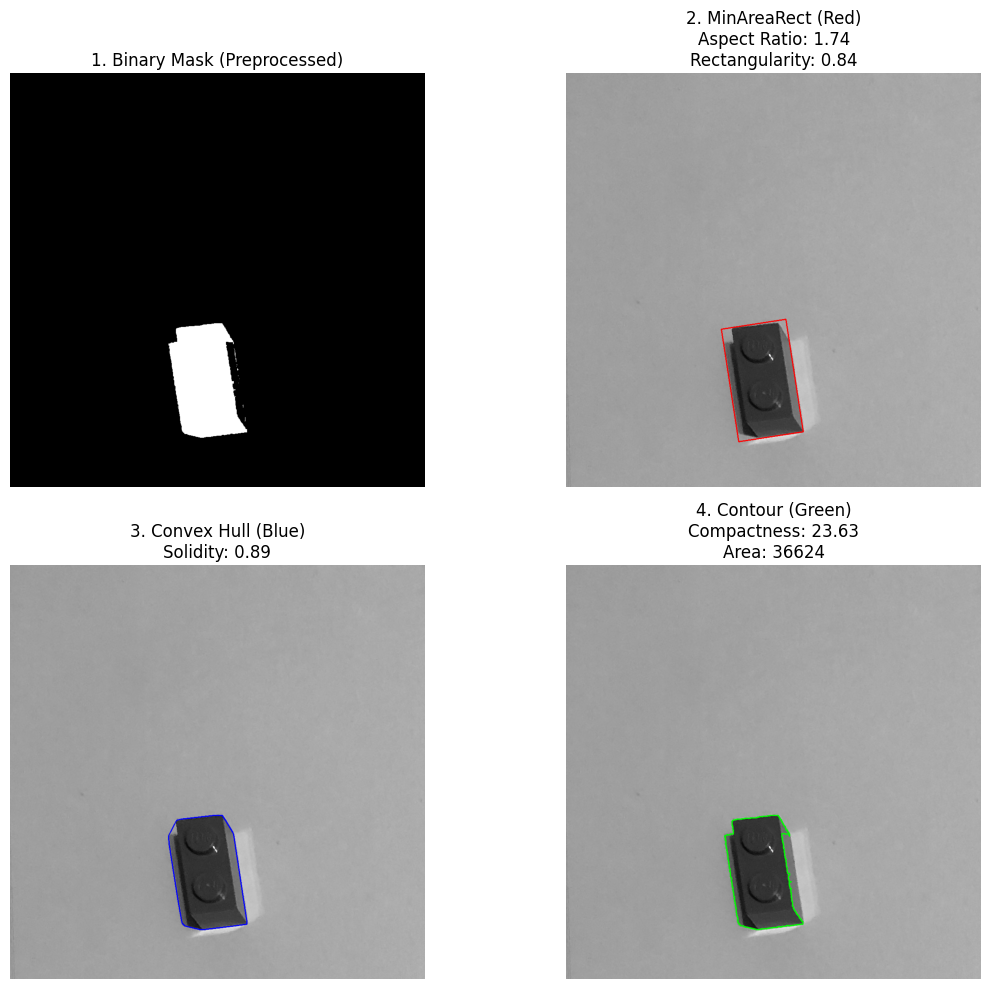

In [78]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

def visualize_single_image_process(image_path):
    """
    Loads a single image and generates a visualization of the 
    geometric features used in Stage 2.
    """
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return

    # 1. Load and Preprocess
    # ---------------------------------------------------------
    im = Image.open(image_path).convert('L')
    im_array = np.array(im)
    
    # Invert and Threshold (Otsu)
    if im_array.dtype != np.uint8:
        im_array = im_array.astype(np.uint8)
    inv_im = cv2.bitwise_not(im_array)
    _, binary = cv2.threshold(inv_im, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Morphological Closing (5x5 kernel)
    kernel = np.ones((5,5), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    
    # 2. Find Contour
    # ---------------------------------------------------------
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print("No contours found.")
        return
    cnt = max(contours, key=cv2.contourArea)
    
    # 3. Calculate Geometry & Draw Visualizations
    # ---------------------------------------------------------
    
    # Convert to BGR for drawing colored lines
    canvas = cv2.cvtColor(im_array, cv2.COLOR_GRAY2BGR)
    canvas_rect = canvas.copy()
    canvas_hull = canvas.copy()
    canvas_contour = canvas.copy()
    
    # --- Feature A: MinAreaRect (Rotated Box) ---
    # Used for: Aspect Ratio, Rectangularity, Orientation
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int32(box)
    
    # Draw Rotated Box in RED
    cv2.drawContours(canvas_rect, [box], 0, (255, 0, 0), 2)
    
    # Calc values for display
    (center), (width, height), angle = rect
    dims = sorted([width, height])
    aspect_ratio = dims[1] / dims[0] if dims[0] > 0 else 0
    rect_area = width * height
    obj_area = cv2.contourArea(cnt)
    rectangularity = obj_area / rect_area if rect_area > 0 else 0

    # --- Feature B: Convex Hull ---
    # Used for: Solidity (Area / Hull Area)
    hull = cv2.convexHull(cnt)
    
    # Draw Hull in BLUE
    cv2.drawContours(canvas_hull, [hull], -1, (0, 0, 255), 2)
    
    # Calc values
    hull_area = cv2.contourArea(hull)
    solidity = obj_area / hull_area if hull_area > 0 else 0

    # --- Feature C: Raw Contour ---
    # Used for: Compactness (Perimeter^2 / Area)
    
    # Draw Contour in GREEN
    cv2.drawContours(canvas_contour, [cnt], -1, (0, 255, 0), 2)
    
    # Calc values
    perimeter = cv2.arcLength(cnt, True)
    compactness = (perimeter**2) / obj_area if obj_area > 0 else 0

    # 4. Plotting
    # ---------------------------------------------------------
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot 1: Binary Mask (Computer View)
    axes[0,0].imshow(binary, cmap='gray')
    axes[0,0].set_title("1. Binary Mask (Preprocessed)")
    axes[0,0].axis('off')
    
    # Plot 2: Rotated Rect (Aspect Ratio)
    axes[0,1].imshow(canvas_rect)
    axes[0,1].set_title(f"2. MinAreaRect (Red)\nAspect Ratio: {aspect_ratio:.2f}\nRectangularity: {rectangularity:.2f}")
    axes[0,1].axis('off')
    
    # Plot 3: Convex Hull (Solidity)
    axes[1,0].imshow(canvas_hull)
    axes[1,0].set_title(f"3. Convex Hull (Blue)\nSolidity: {solidity:.2f}")
    axes[1,0].axis('off')
    
    # Plot 4: Contour (Compactness)
    axes[1,1].imshow(canvas_contour)
    axes[1,1].set_title(f"4. Contour (Green)\nCompactness: {compactness:.2f}\nArea: {obj_area:.0f}")
    axes[1,1].axis('off')
    
    plt.tight_layout()
    plt.show()

# =========================================================
# RUN THE VISUALIZATION
# =========================================================
# Pick one image from your training set to test
# Replace this filename with an actual file from your folder
sample_image_path = 'Lego_dataset_2/training/2025_01.jpg' 

# Safety check: grab the first file found in the folder if the specific name doesn't exist
train_dir = 'Lego_dataset_2/training/'
if os.path.exists(train_dir):
    files = [f for f in os.listdir(train_dir) if f.endswith('jpg') or f.endswith('png')]
    if files:
        visualize_single_image_process(os.path.join(train_dir, files[0]))
    else:
        print("No images found in directory.")
else:
    print("Directory not found.")
